# Day 2: Ridge Regression (L2 Regularization) for Trading

## 🎯 Learning Objectives
- Understand L2 regularization and its benefits
- Handle multicollinearity in financial features
- Tune lambda parameter for optimal prediction
- Compare Ridge vs OLS performance

---

## 📚 Theory: Ridge Regression

### The Problem with OLS
When features are highly correlated (multicollinearity), OLS estimates become unstable with high variance.

### Ridge Solution
Add L2 penalty to shrink coefficients:
$$\hat{\beta}_{ridge} = \arg\min_\beta \left[ \sum_{i=1}^n (y_i - x_i^T\beta)^2 + \lambda\sum_{j=1}^p \beta_j^2 \right]$$

### Closed-Form Solution
$$\hat{\beta}_{ridge} = (X^TX + \lambda I)^{-1}X^Ty$$

### Bias-Variance Trade-off
- **λ = 0**: OLS (high variance, low bias)
- **λ → ∞**: All coefficients → 0 (high bias, low variance)
- **Optimal λ**: Balance via cross-validation

### Pros & Cons

| Pros | Cons |
|------|------|
| Handles multicollinearity | Doesn't perform feature selection |
| Reduces overfitting | All features kept |
| Stable predictions | Less interpretable |
| Works with p > n | Requires standardization |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'GS', 'SPY', 'QQQ']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1255 days, 10 assets


In [2]:
# Create MANY correlated features (to demonstrate Ridge benefit)
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Multiple momentum features (highly correlated)
for lag in [1, 2, 3, 5, 10, 15, 20, 30]:
    df[f'momentum_{lag}'] = prices[target_stock].pct_change(lag)

# Multiple MA ratios (correlated)
for window in [5, 10, 20, 50, 100]:
    df[f'ma_ratio_{window}'] = prices[target_stock] / prices[target_stock].rolling(window).mean() - 1

# Volatility features
for window in [5, 10, 20, 30]:
    df[f'volatility_{window}'] = returns[target_stock].rolling(window).std()

# Cross-asset features
for ticker in ['SPY', 'QQQ', 'MSFT', 'GOOGL']:
    df[f'{ticker}_return'] = returns[ticker]
    df[f'{ticker}_momentum'] = prices[ticker].pct_change(5)

# Target
df['target'] = returns[target_stock].shift(-1)
df = df.dropna()

print(f"\n📊 Total Features: {len(df.columns)-1}")
print(f"📈 Samples: {len(df)}")


📊 Total Features: 25
📈 Samples: 1156


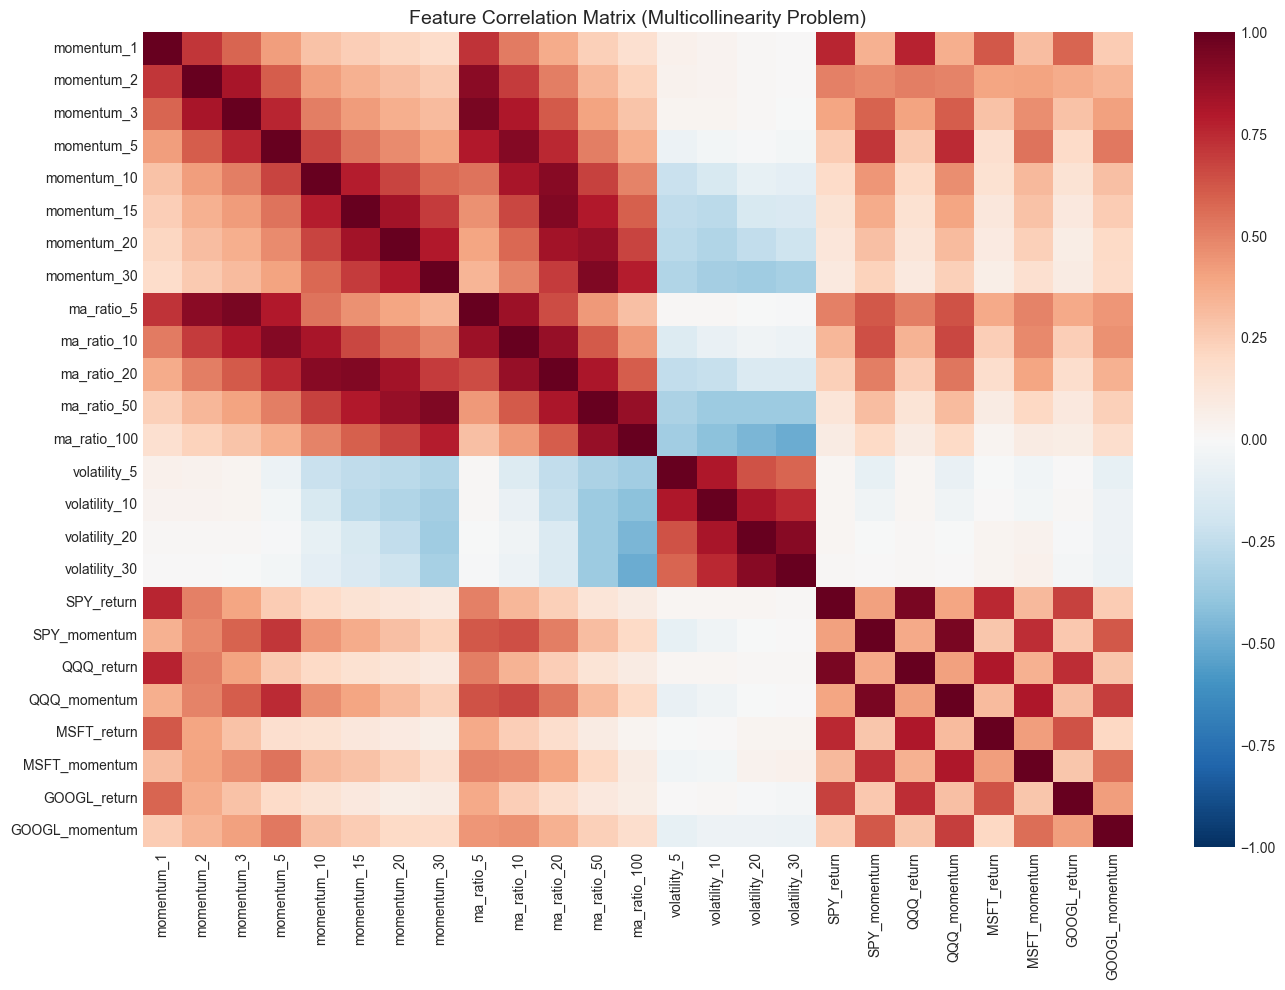


⚠️ Pairs with |correlation| > 0.8: 25


In [3]:
# Show multicollinearity problem
feature_cols = [c for c in df.columns if c != 'target']
corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
            xticklabels=True, yticklabels=True, annot=False)
plt.title('Feature Correlation Matrix (Multicollinearity Problem)', fontsize=14)
plt.tight_layout()
plt.show()

# Count high correlations
high_corr = (np.abs(corr_matrix) > 0.8).sum().sum() - len(feature_cols)  # Exclude diagonal
print(f"\n⚠️ Pairs with |correlation| > 0.8: {high_corr // 2}")

In [4]:
# Prepare data
X = df[feature_cols]
y = df['target']

# Train/Test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# IMPORTANT: Scale features for Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 924, Test: 232


In [5]:
# Compare OLS vs Ridge with different alphas
alphas = np.logspace(-4, 4, 50)

# Store results
train_errors = []
test_errors = []
coef_norms = []

# OLS baseline
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
ols_train_mse = mean_squared_error(y_train, ols.predict(X_train_scaled))
ols_test_mse = mean_squared_error(y_test, ols.predict(X_test_scaled))

# Ridge for different alphas
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    train_mse = mean_squared_error(y_train, ridge.predict(X_train_scaled))
    test_mse = mean_squared_error(y_test, ridge.predict(X_test_scaled))
    coef_norm = np.sqrt(np.sum(ridge.coef_**2))
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    coef_norms.append(coef_norm)

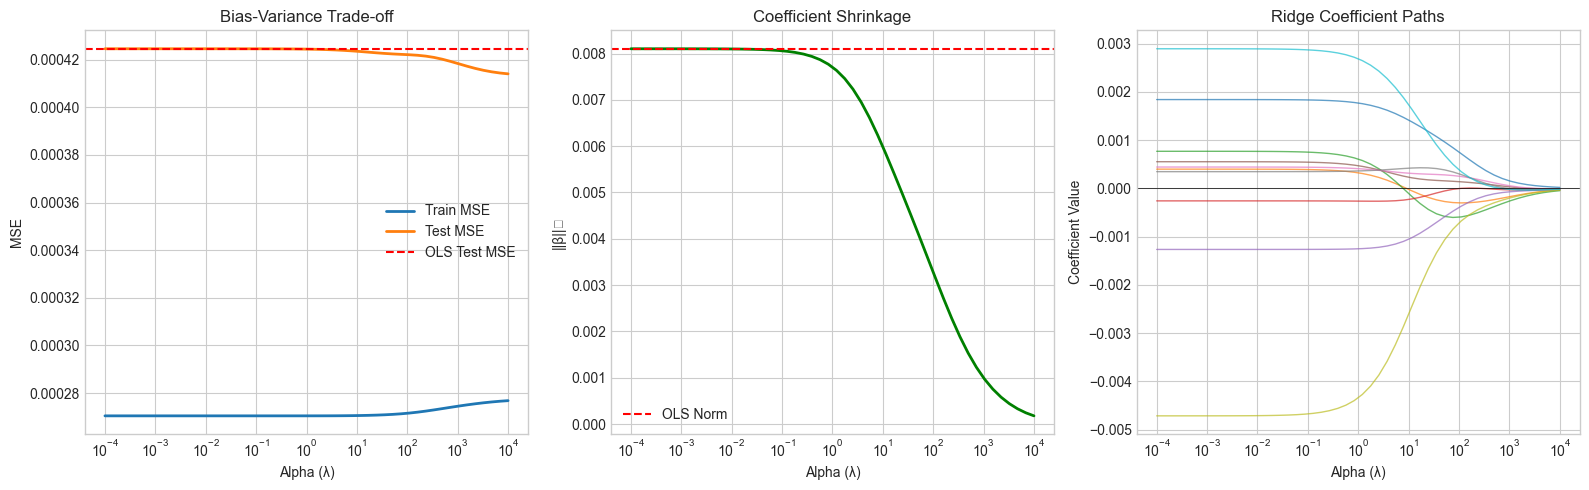

In [6]:
# Plot Ridge regularization path
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MSE vs Alpha
axes[0].semilogx(alphas, train_errors, label='Train MSE', linewidth=2)
axes[0].semilogx(alphas, test_errors, label='Test MSE', linewidth=2)
axes[0].axhline(y=ols_test_mse, color='r', linestyle='--', label='OLS Test MSE')
axes[0].set_xlabel('Alpha (λ)')
axes[0].set_ylabel('MSE')
axes[0].set_title('Bias-Variance Trade-off')
axes[0].legend()

# Coefficient Norm vs Alpha
axes[1].semilogx(alphas, coef_norms, linewidth=2, color='green')
axes[1].axhline(y=np.sqrt(np.sum(ols.coef_**2)), color='r', linestyle='--', label='OLS Norm')
axes[1].set_xlabel('Alpha (λ)')
axes[1].set_ylabel('||β||₂')
axes[1].set_title('Coefficient Shrinkage')
axes[1].legend()

# Coefficient paths
coef_paths = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    coef_paths.append(ridge.coef_)
coef_paths = np.array(coef_paths)

for i in range(min(10, coef_paths.shape[1])):
    axes[2].semilogx(alphas, coef_paths[:, i], linewidth=1, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_xlabel('Alpha (λ)')
axes[2].set_ylabel('Coefficient Value')
axes[2].set_title('Ridge Coefficient Paths')

plt.tight_layout()
plt.show()

In [7]:
# Cross-validation to find optimal alpha
tscv = TimeSeriesSplit(n_splits=5)
alphas_cv = np.logspace(-3, 3, 100)

ridge_cv = RidgeCV(alphas=alphas_cv, cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

optimal_alpha = ridge_cv.alpha_
print(f"\n✅ Optimal Alpha (via CV): {optimal_alpha:.4f}")


✅ Optimal Alpha (via CV): 1000.0000


In [8]:
# Final Model Comparison
# Train optimal Ridge
ridge_optimal = Ridge(alpha=optimal_alpha)
ridge_optimal.fit(X_train_scaled, y_train)

# Predictions
ols_pred = ols.predict(X_test_scaled)
ridge_pred = ridge_optimal.predict(X_test_scaled)

print("\n" + "="*60)
print("MODEL COMPARISON: OLS vs RIDGE")
print("="*60)

metrics = ['R² Score', 'RMSE', 'MAE', 'Directional Acc.']
ols_metrics = [
    r2_score(y_test, ols_pred),
    np.sqrt(mean_squared_error(y_test, ols_pred)),
    mean_absolute_error(y_test, ols_pred),
    (np.sign(ols_pred) == np.sign(y_test)).mean()
]
ridge_metrics = [
    r2_score(y_test, ridge_pred),
    np.sqrt(mean_squared_error(y_test, ridge_pred)),
    mean_absolute_error(y_test, ridge_pred),
    (np.sign(ridge_pred) == np.sign(y_test)).mean()
]

print(f"\n{'Metric':<20} {'OLS':>15} {'Ridge':>15}")
print("-" * 50)
for m, o, r in zip(metrics, ols_metrics, ridge_metrics):
    print(f"{m:<20} {o:>15.4f} {r:>15.4f}")


MODEL COMPARISON: OLS vs RIDGE

Metric                           OLS           Ridge
--------------------------------------------------
R² Score                     -0.0283         -0.0133
RMSE                          0.0206          0.0205
MAE                           0.0127          0.0125
Directional Acc.              0.5345          0.5129


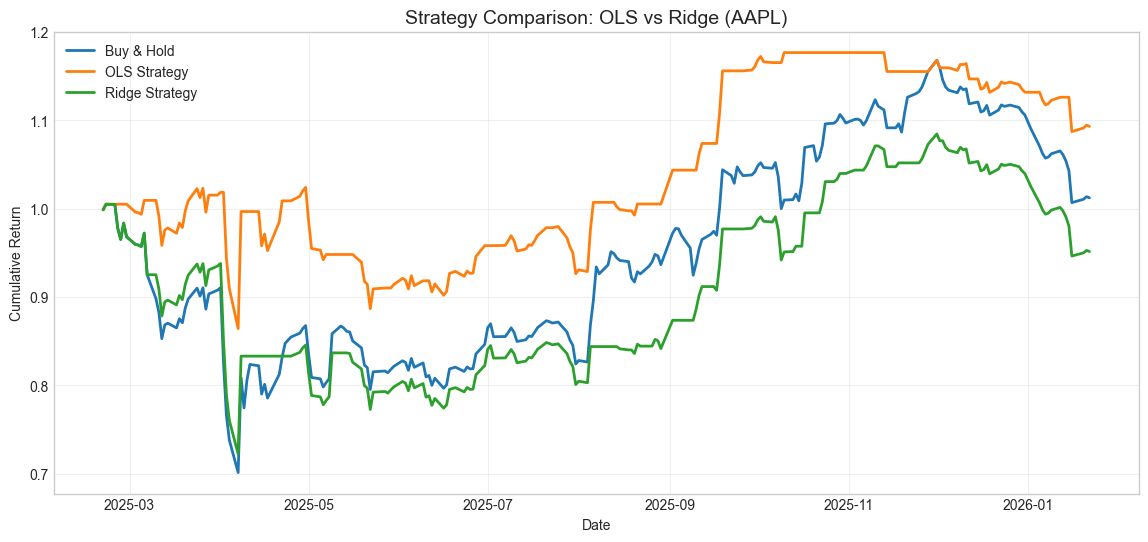

In [9]:
# Trading Strategy Comparison
backtest = pd.DataFrame(index=y_test.index)
backtest['actual'] = y_test.values
backtest['ols_pred'] = ols_pred
backtest['ridge_pred'] = ridge_pred

# Signals
backtest['ols_signal'] = np.where(backtest['ols_pred'] > 0, 1, 0)
backtest['ridge_signal'] = np.where(backtest['ridge_pred'] > 0, 1, 0)

# Returns
backtest['buy_hold'] = backtest['actual']
backtest['ols_return'] = backtest['ols_signal'] * backtest['actual']
backtest['ridge_return'] = backtest['ridge_signal'] * backtest['actual']

# Cumulative
backtest['buy_hold_cum'] = (1 + backtest['buy_hold']).cumprod()
backtest['ols_cum'] = (1 + backtest['ols_return']).cumprod()
backtest['ridge_cum'] = (1 + backtest['ridge_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['ols_cum'], label='OLS Strategy', linewidth=2)
plt.plot(backtest.index, backtest['ridge_cum'], label='Ridge Strategy', linewidth=2)
plt.title(f'Strategy Comparison: OLS vs Ridge ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])
ridge_next_pred = ridge_optimal.predict(latest_scaled)[0]
ols_next_pred = ols.predict(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nOLS Predicted Return: {ols_next_pred:.4%}")
print(f"Ridge Predicted Return: {ridge_next_pred:.4%}")
print(f"\nRidge Signal: {'📈 LONG' if ridge_next_pred > 0 else '📉 STAY OUT'}")
print(f"Optimal Alpha Used: {optimal_alpha:.4f}")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-22

OLS Predicted Return: 0.3345%
Ridge Predicted Return: 0.2355%

Ridge Signal: 📈 LONG
Optimal Alpha Used: 1000.0000


---

## 🏢 Real-World Applications

| Company | Ridge Regression Use |
|---------|---------------------|
| Two Sigma | High-dimensional alpha modeling |
| DE Shaw | Factor exposure estimation |
| Point72 | Cross-sectional return prediction |
| Millennium | Risk model calibration |

### Key Interview Points
1. **Why Ridge over OLS?** - Handles multicollinearity, reduces overfitting
2. **Feature scaling?** - CRITICAL for Ridge (penalty treats all features equally)
3. **Ridge vs Lasso?** - Ridge keeps all features, Lasso performs selection

---
## 📅 Tomorrow: Lasso Regression (Feature Selection)